In [5]:
import glob
base_path = '../p0605/xray_classification_pneumonia/Dataset_compressed/train'
file_path = list(glob.glob(base_path + "/*/*.*"))
pneumonia = list(glob.glob(base_path+"/PNEUMONIA/*.*"))
normal = list(glob.glob(base_path+"/NORMAL/*.*"))

In [6]:
len(pneumonia), len(normal)

(3875, 1341)

In [7]:
import matplotlib.pyplot as plt
import os
test = os.path.dirname(file_path[0])
print(test)
class_name = os.path.split(os.path.dirname(test))
print(class_name)

../p0605/xray_classification_pneumonia/Dataset_compressed/train\NORMAL
('../p0605/xray_classification_pneumonia/Dataset_compressed', 'train')


In [8]:
# folder name to label
labels = []
for fp in file_path:
    tmp = os.path.dirname(fp)
    class_name = os.path.split(tmp)
    if class_name[1] == "PNEUMONIA":
        labels.append(1)
    else:
        labels.append(0)

In [9]:
import numpy as np
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2
img_width = 60
img_height = 60
dataset = np.ndarray(shape=(len(file_path), img_height*img_width), dtype=np.float32)
i=0
for _file in file_path:
    img = cv2.imread(_file, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (img_width, img_height))
    
    dataset[i] = img_resized.flatten()
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
X_train,X_test,y_train,y_test = train_test_split(dataset,labels,test_size=0.2,random_state=42)

In [15]:
len(X_train),len(X_test),len(y_train),len(y_test)

(4172, 1044, 4172, 1044)

In [17]:
y_train, y_test = map(lambda x: to_categorical(x),[y_train,y_test])

### 모델 생성 

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers 

In [20]:
def build():
    model = Sequential()
    model.add(Dense(100,activation='relu',input_shape=(3600,)))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    
    return model

model = build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               360100    
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 365,252
Trainable params: 365,252
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.predict(dataset)

163/163 [==============================] - 1s 2ms/step


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Adam 학습 

In [24]:
model_adam = build()

model_adam.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model_adam.fit(
    X_train,y_train,validation_data=(X_test,y_test),batch_size=64,epochs=20
)

Epoch 1/20
66/66 [==============================] - 1s 8ms/step - loss: 28.8019 - accuracy: 0.7792 - val_loss: 1.7964 - val_accuracy: 0.9186
Epoch 2/20
66/66 [==============================] - 0s 4ms/step - loss: 8.3421 - accuracy: 0.8255 - val_loss: 16.1480 - val_accuracy: 0.7902
Epoch 3/20
66/66 [==============================] - 0s 4ms/step - loss: 4.2456 - accuracy: 0.8986 - val_loss: 2.2922 - val_accuracy: 0.9282
Epoch 4/20
66/66 [==============================] - 0s 4ms/step - loss: 3.5615 - accuracy: 0.9039 - val_loss: 1.7265 - val_accuracy: 0.9464
Epoch 5/20
66/66 [==============================] - 0s 4ms/step - loss: 2.2025 - accuracy: 0.9233 - val_loss: 2.1006 - val_accuracy: 0.9339
Epoch 6/20
66/66 [==============================] - 0s 4ms/step - loss: 1.4808 - accuracy: 0.9473 - val_loss: 3.9884 - val_accuracy: 0.8860
Epoch 7/20
66/66 [==============================] - 0s 4ms/step - loss: 1.4007 - accuracy: 0.9470 - val_loss: 3.0729 - val_accuracy: 0.8898
Epoch 8/20
66/66 [

### 예측 

In [28]:
import matplotlib.pyplot as plt
import numpy as np 
predictions = model_adam.predict(X_test)
predicted_class = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

33/33 [==============================] - 0s 2ms/step


### 정확도 계산 

In [29]:
accuracy = np.mean(predicted_class == true_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.25%


### 시각화 

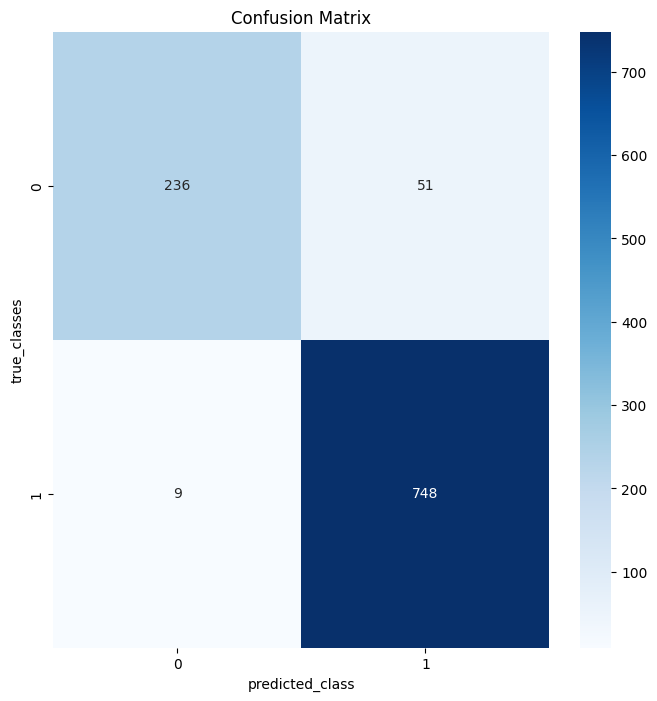

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_classes, predicted_class)
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted_class')
plt.ylabel('true_classes')
plt.show()

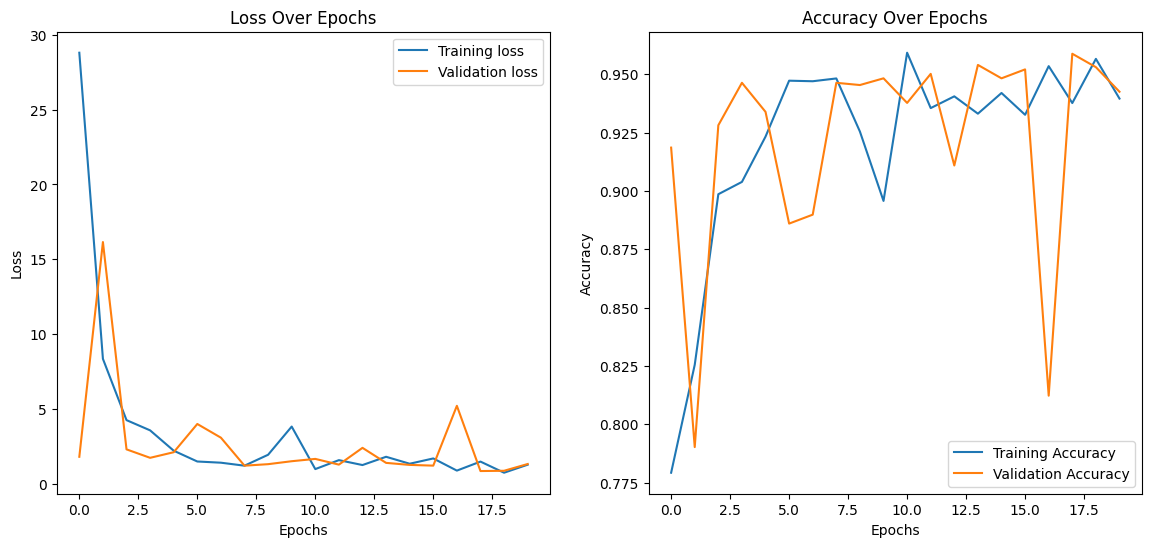

In [33]:
# Train, Val 시각화 - Loss
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()